In [1]:
import os
import re
import ast
import importlib
import uuid
import json
import ast

from dotenv import load_dotenv
from typing import Dict, List, Any, Optional, Annotated, Union, Literal
from typing_extensions import TypedDict
from enum import Enum

from langchain_openai import ChatOpenAI
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage, filter_messages
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import MessagesState

from langgraph.prebuilt import tools_condition, ToolNode

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.errors import NodeInterrupt

from IPython.display import Image, display

from langchain_core.prompts import ChatPromptTemplate

In [2]:
load_dotenv()

True

In [3]:
db = SQLDatabase.from_uri("sqlite:///../sql-support-bot/chinook.db")
print(db.get_usable_table_names())

['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


In [4]:
os.environ["LANGCHAIN_PROJECT"] = "music-store-support-demo-prep"

# Set up LLMs, state and interrupt messages

In [5]:
helpdesk_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
account_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
music_recommendation_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

In [6]:
class NodeType(str, Enum):
    ROUTER = "router"
    QUERY = "query"
    UPDATE = "update"
    HUMAN_APPROVAL = "human_approval"
    RESPONSE = "response"

class MusicStoreChatbotState(MessagesState):
    customer_id: Optional[int]
    next_node: NodeType
    approved: Optional[bool]
    current_mode: Literal["router", "account", "music"]

In [7]:
customer_id_interrupt_message = "Please provide your customer ID to help me assist you better."
action_confirmation_interrupt_message = "This action will update the database. Please confirm that you want to proceed (yes/no)"

# Helper Functions

In [8]:
def get_last_human_message(messages: List[BaseMessage]) -> Optional[HumanMessage]:
    """Extract the last human message from the conversation history."""
    for message in reversed(messages):
        if isinstance(message, HumanMessage):
            return message
    return None

# Music Recommendation Agent

## Create Artist and Song retrievers to allow inexact matching of for artists and tracks/songs names

In [9]:
artists = db._execute("SELECT * FROM artists")
songs = db._execute("SELECT * FROM tracks")
artist_retriever = SKLearnVectorStore.from_texts(
    [a['Name'] for a in artists],
    OpenAIEmbeddings(),
    metadatas=artists
).as_retriever()

song_retriever = SKLearnVectorStore.from_texts(
    [a['Name'] for a in songs],
    OpenAIEmbeddings(),
    metadatas=songs
).as_retriever()

## Define Tools to get recommendations

### Tools not specific to a customer

In [10]:
@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist (or similar artists)."""
    docs = artist_retriever.invoke(artist)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"SELECT Title, Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId WHERE albums.ArtistId in ({artist_ids});",
        include_columns=True)


@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    docs = artist_retriever.invoke(artist)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"SELECT tracks.Name as SongName, artists.Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId LEFT JOIN tracks ON tracks.AlbumId = albums.AlbumId WHERE albums.ArtistId in ({artist_ids});",
        include_columns=True)


@tool
def search_songs(song_title: str):
    """Search for songs by title."""
    docs = song_retriever.invoke(song_title)
    return [{"Title": doc.page_content, "TrackId": doc.metadata["TrackId"]} for doc in docs[:5]]


@tool
def get_similar_music(genre: str, artist: str = ""):
    """Get music recommendations based on genre and optionally artist."""
    # Find genre ID
    genre_query = f"""
    SELECT GenreId FROM genres 
    WHERE Name LIKE '%{genre}%' 
    LIMIT 1
    """
    genre_result = db.run(genre_query)
    if not genre_result:
        return f"No genre found matching '{genre}'"

    # Genre result comes as a string like "[(1,)]" - parse it
    genre_id = int(genre_result.strip("[]() \t\n,").split(",")[0])

    # Get tracks in that genre, optionally filtering by artist
    artist_filter = ""
    if artist:
        docs = artist_retriever.invoke(artist)
        print(f"docs = {docs}")
        if docs:
            artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
            artist_filter = f"AND albums.ArtistId IN ({artist_ids})"
    
    query = f"""
    SELECT tracks.Name as TrackName, artists.Name as ArtistName, albums.Title as AlbumTitle
    FROM tracks
    JOIN albums ON tracks.AlbumId = albums.AlbumId
    JOIN artists ON albums.ArtistId = artists.ArtistId
    WHERE tracks.GenreId = {genre_id} {artist_filter}
    ORDER BY RANDOM()
    LIMIT 5
    """
    
    result = db.run(query, include_columns=True)
    
    if not result:
        return f"No songs found for genre '{genre}'" + (f" and artist '{artist}'" if artist else "")
    
    try:
        # Try using ast.literal_eval which is safer than eval
        tracks = ast.literal_eval(result)
    except:
        try:
            # If ast fails, try json.loads (might need some string cleaning)
            # Replace single quotes with double quotes for valid JSON
            cleaned_result = result.replace("'", '"')
            tracks = json.loads(cleaned_result)
        except:
            # If both methods fail, return an error message
            return "Error parsing database results. Please check the result format."
    
    formatted_result = "Here are some similar tracks:\n\n"
    for track in tracks:
        formatted_result += f"- {track['TrackName']} by {track['ArtistName']} (Album: {track['AlbumTitle']})\n"
    
    return formatted_result

### Tools specific to a customer

In [11]:
@tool
def get_customer_top_genres(customer_id: int, limit: int = 5):
    """Identify a customer's favorite genres based on purchase history."""
    return db.run(f"""
        SELECT g.Name as Genre, COUNT(ii.InvoiceLineId) as PurchaseCount
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        WHERE i.CustomerId = {customer_id}
        GROUP BY g.GenreId
        ORDER BY PurchaseCount DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def get_customer_top_artists(customer_id: int, limit: int = 5):
    """Identify a customer's favorite artists based on purchase history."""
    return db.run(f"""
        SELECT ar.Name as Artist, COUNT(ii.InvoiceLineId) as PurchaseCount,
               SUM(ii.UnitPrice) as TotalSpent
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        GROUP BY ar.ArtistId
        ORDER BY PurchaseCount DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def check_track_purchase_history(customer_id: int, track_name: str):
    """Check if and when a customer purchased a specific track."""
    # First, find tracks that match the provided name
    docs = song_retriever.invoke(track_name)
    if not docs:
        return f"No tracks found matching '{track_name}'"
    
    track_ids = ", ".join([str(doc.metadata['TrackId']) for doc in docs[:5]])
    
    return db.run(f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist, 
               al.Title as Album, ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id} AND t.TrackId IN ({track_ids})
        ORDER BY i.InvoiceDate DESC;
    """, include_columns=True)

@tool
def get_recommended_tracks_from_purchase_history(customer_id: int, limit: int = 5):
    """Get personalized track recommendations based on purchase history."""
    # First, get the customer's top genres
    top_genres_query = """
        SELECT g.Name as Genre
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        WHERE i.CustomerId = {customer_id}
        GROUP BY g.GenreId
        ORDER BY COUNT(ii.InvoiceLineId) DESC
        LIMIT 2;
    """.format(customer_id=customer_id)
    
    genres_result = db.run(top_genres_query, include_columns=True)
    
    if not genres_result:
        return "No purchase history found to base recommendations on."
    
    # Get customer's purchased tracks to exclude them
    purchased_tracks_query = """
        SELECT t.TrackId
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        WHERE i.CustomerId = {customer_id};
    """.format(customer_id=customer_id)
    
    purchased_tracks_result = db.run(purchased_tracks_query)
    purchased_track_ids = []
    if purchased_tracks_result:
        # Extract track IDs from the SQL result
        for row in purchased_tracks_result.strip('[]').split('), ('):
            track_id = row.strip('()').split(',')[0]
            if track_id.isdigit():
                purchased_track_ids.append(int(track_id))
    
    # Get top artists (optional enhancement)
    top_artist_query = """
        SELECT ar.Name as Artist
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        GROUP BY ar.ArtistId
        ORDER BY COUNT(ii.InvoiceLineId) DESC
        LIMIT 1;
    """.format(customer_id=customer_id)
    
    artist_result = db.run(top_artist_query, include_columns=True)
    top_artist = artist_result[0]['Artist'] if artist_result else ""
    
    # Use the existing get_similar_music with the top genre
    recommendations = get_similar_music(genres_result[0]['Genre'], top_artist)
    
    # You could filter out already purchased tracks here if needed
    
    return recommendations

In [12]:
@tool
def summarize_music_taste(customer_id: int):
    """Provide a comprehensive analysis of the customer's music taste based on purchase history."""
    print(f"Analyzing music taste for customer {customer_id}")
    
    # Basic purchase statistics
    basic_stats_query = f"""
    SELECT 
        COUNT(DISTINCT ii.TrackId) AS TotalTracks,
        COUNT(DISTINCT i.InvoiceId) AS TotalPurchases,
        SUM(i.Total) AS TotalSpent,
        MIN(i.InvoiceDate) AS FirstPurchase,
        MAX(i.InvoiceDate) AS LastPurchase,
        COUNT(DISTINCT ar.ArtistId) AS UniqueArtists,
        COUNT(DISTINCT g.GenreId) AS UniqueGenres,
        COUNT(DISTINCT al.AlbumId) AS UniqueAlbums
    FROM invoices i
    JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN albums al ON t.AlbumId = al.AlbumId
    JOIN artists ar ON al.ArtistId = ar.ArtistId
    JOIN genres g ON t.GenreId = g.GenreId
    WHERE i.CustomerId = {customer_id}
    """
    basic_stats = db.run(basic_stats_query, include_columns=True)
    
    if not basic_stats:
        return {"error": "No purchase history found for this customer."}
    
    # Genre preferences with percentages
    genre_query = f"""
    SELECT 
        g.Name AS Genre, 
        COUNT(ii.InvoiceLineId) AS TrackCount,
        ROUND((COUNT(ii.InvoiceLineId) * 100.0) / (
            SELECT COUNT(ii2.InvoiceLineId) 
            FROM invoice_items ii2
            JOIN invoices i2 ON ii2.InvoiceId = i2.InvoiceId
            WHERE i2.CustomerId = {customer_id}
        ), 2) AS Percentage
    FROM invoice_items ii
    JOIN invoices i ON ii.InvoiceId = i.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN genres g ON t.GenreId = g.GenreId
    WHERE i.CustomerId = {customer_id}
    GROUP BY g.GenreId
    ORDER BY TrackCount DESC
    LIMIT 8
    """
    genres = db.run(genre_query, include_columns=True)
    
    # Top artists with purchase counts and percentage of collection
    artist_query = f"""
    SELECT 
        ar.Name AS Artist, 
        COUNT(ii.InvoiceLineId) AS TrackCount,
        ROUND((COUNT(ii.InvoiceLineId) * 100.0) / (
            SELECT COUNT(ii2.InvoiceLineId) 
            FROM invoice_items ii2
            JOIN invoices i2 ON ii2.InvoiceId = i2.InvoiceId
            WHERE i2.CustomerId = {customer_id}
        ), 2) AS Percentage,
        COUNT(DISTINCT al.AlbumId) AS AlbumCount
    FROM invoice_items ii
    JOIN invoices i ON ii.InvoiceId = i.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN albums al ON t.AlbumId = al.AlbumId
    JOIN artists ar ON al.ArtistId = ar.ArtistId
    WHERE i.CustomerId = {customer_id}
    GROUP BY ar.ArtistId
    ORDER BY TrackCount DESC
    LIMIT 8
    """
    artists = db.run(artist_query, include_columns=True)
    
    # Favorite albums (albums with the most tracks purchased)
    album_query = f"""
    SELECT 
        al.Title AS Album, 
        ar.Name AS Artist,
        COUNT(ii.InvoiceLineId) AS TrackCount,
        COUNT(DISTINCT t.TrackId) AS UniqueTrackCount,
        (SELECT COUNT(t2.TrackId) FROM tracks t2 WHERE t2.AlbumId = al.AlbumId) AS TotalAlbumTracks,
        ROUND((COUNT(DISTINCT t.TrackId) * 100.0) / (SELECT COUNT(t2.TrackId) FROM tracks t2 WHERE t2.AlbumId = al.AlbumId), 2) AS AlbumCompletion
    FROM invoice_items ii
    JOIN invoices i ON ii.InvoiceId = i.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN albums al ON t.AlbumId = al.AlbumId
    JOIN artists ar ON al.ArtistId = ar.ArtistId
    WHERE i.CustomerId = {customer_id}
    GROUP BY al.AlbumId
    ORDER BY TrackCount DESC
    LIMIT 5
    """
    albums = db.run(album_query, include_columns=True)
    
    # Purchase trends over time (by quarter)
    trends_query = f"""
    SELECT 
        strftime('%Y-%m', i.InvoiceDate) AS Period,
        COUNT(ii.InvoiceLineId) AS Purchases,
        COUNT(DISTINCT g.GenreId) AS GenresDiversity,
        GROUP_CONCAT(DISTINCT g.Name) AS Genres
    FROM invoices i
    JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN genres g ON t.GenreId = g.GenreId
    WHERE i.CustomerId = {customer_id}
    GROUP BY Period
    ORDER BY Period ASC
    """
    purchase_trends = db.run(trends_query, include_columns=True)
    
    # Compare to store average (for main genres)
    comparison_query = f"""
    WITH CustomerGenres AS (
        SELECT 
            g.GenreId, 
            g.Name AS Genre,
            COUNT(ii.InvoiceLineId) AS TrackCount,
            ROUND((COUNT(ii.InvoiceLineId) * 100.0) / (
                SELECT COUNT(ii2.InvoiceLineId) 
                FROM invoice_items ii2
                JOIN invoices i2 ON ii2.InvoiceId = i2.InvoiceId
                WHERE i2.CustomerId = {customer_id}
            ), 2) AS Percentage
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        WHERE i.CustomerId = {customer_id}
        GROUP BY g.GenreId
    ),
    StoreAverage AS (
        SELECT 
            g.GenreId,
            g.Name AS Genre,
            COUNT(ii.InvoiceLineId) AS TotalTracks,
            ROUND((COUNT(ii.InvoiceLineId) * 100.0) / (
                SELECT COUNT(ii2.InvoiceLineId) FROM invoice_items ii2
            ), 2) AS StorePercentage
        FROM invoice_items ii
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        GROUP BY g.GenreId
    )
    SELECT 
        cg.Genre,
        cg.TrackCount,
        cg.Percentage AS CustomerPercentage,
        sa.StorePercentage,
        ROUND(cg.Percentage - sa.StorePercentage, 2) AS Difference
    FROM CustomerGenres cg
    JOIN StoreAverage sa ON cg.GenreId = sa.GenreId
    ORDER BY ABS(Difference) DESC
    LIMIT 5
    """
    comparisons = db.run(comparison_query, include_columns=True)
    
    # Most recent purchases to show current interests
    recent_query = f"""
    SELECT 
        t.Name AS Track, 
        ar.Name AS Artist,
        g.Name AS Genre,
        i.InvoiceDate
    FROM invoices i
    JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN albums al ON t.AlbumId = al.AlbumId
    JOIN artists ar ON al.ArtistId = ar.ArtistId
    JOIN genres g ON t.GenreId = g.GenreId
    WHERE i.CustomerId = {customer_id}
    ORDER BY i.InvoiceDate DESC
    LIMIT 5
    """
    recent_purchases = db.run(recent_query, include_columns=True)
    
    # Return comprehensive analysis
    return {
        "basic_stats": basic_stats[0] if basic_stats else {},
        "genre_distribution": genres,
        "top_artists": artists,
        "favorite_albums": albums,
        "purchase_trends": purchase_trends,
        "genre_comparison": comparisons,
        "recent_purchases": recent_purchases
    }

In [13]:
music_recommendation_tools = [
    get_albums_by_artist,
    get_tracks_by_artist,
    search_songs,
    get_similar_music,
    get_customer_top_genres,
    get_customer_top_artists,
    check_track_purchase_history,
    get_recommended_tracks_from_purchase_history,
    summarize_music_taste
]
music_recommendation_model_with_tools = music_recommendation_model.bind_tools(music_recommendation_tools)

## Set up graph

### Node to process queries

In [14]:
music_system_message = ChatPromptTemplate.from_template("""You are a music specialist at a music store.
You have extensive knowledge of our music catalog and can assist customers in discovering music they'll love.

FOR ALL CUSTOMERS, YOU CAN:
1. Find albums by specific artists
2. List songs by an artist
3. Search for specific tracks by name
4. Recommend music based on genres or similar artists

FOR AUTHENTICATED CUSTOMERS (when a customer ID is provided), YOU CAN ALSO:
5. Check their purchase history for specific tracks or artists
6. Analyze their music taste based on previous purchases
7. Provide personalized recommendations based on their top genres
8. Suggest new music similar to their favorite artists
9. Summarize their music preferences with insights about their taste

GUIDELINES:
- Be conversational and show enthusiasm about music
- If you can't find exactly what they're looking for, suggest similar alternatives
- When making recommendations, briefly explain why you think they might enjoy them
- For customers with limited purchase history, balance personalized suggestions with popular recommendations
- Use specific examples when discussing artists and genres
- If asked about a purchase they can't recall, offer to check their purchase history

Your goal is to help customers discover music they'll love, whether they're looking for specific tracks or open to new recommendations that match their taste.

The customer ID for this request is {customer_id}
""")


def handle_music_query(state: MusicStoreChatbotState):
    """Handle music-related queries"""
    
    messages = [SystemMessage(content=music_system_message.format(customer_id=state["customer_id"]))]
    context_messages = filter_messages(state["messages"], exclude_types="system")
    # context_messages = state["messages"][-5:] if len(state["messages"]) > 5 else state["messages"]
    messages.extend(context_messages)

    # Let the agent determine what to do next
    response = music_recommendation_model_with_tools.invoke(messages)

    return {
        "messages": state["messages"] + [response]
    }

### Graph Definition

In [15]:
music_recommendation_graph_builder = StateGraph(MusicStoreChatbotState)

music_recommendation_graph_builder.add_node("handle_music_query", handle_music_query)
music_recommendation_graph_builder.add_node("tools", ToolNode(music_recommendation_tools))

# Add the starting edge
music_recommendation_graph_builder.add_edge(START, "handle_music_query")
music_recommendation_graph_builder.add_conditional_edges(
    "handle_music_query",
    # If the latest message from assistant 
    # is a tool call -> tools_condition routes to tools
    # is a not a tool call -> tools_condition routes to END
    tools_condition,
)
music_recommendation_graph_builder.add_edge("tools", "handle_music_query")
music_recommendation_graph_builder.add_edge("handle_music_query", END)

music_recommendation_memory = MemorySaver()
music_recommendation_graph = music_recommendation_graph_builder.compile(checkpointer=music_recommendation_memory)

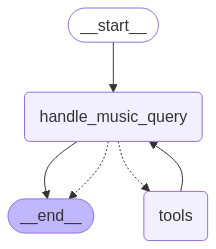

In [16]:
display(Image(music_recommendation_graph.get_graph().draw_mermaid_png()))

## Test

In [17]:
# # Define a thread config dictionary
# thread_config = {"configurable": {"thread_id": "1"}}

# # Then use it in your invoke call
# response = music_recommendation_graph.invoke(
#     {
#         # "messages": [HumanMessage(content="Hey, recommend music by Amy Winehouse")], 
#         # "messages": [HumanMessage(content="Hey, is Boulevard Of Broken Dreams available for purchase?")], 
#         "messages": [HumanMessage(content="Hey, I like Boulevard Of Broken Dreams. What other albums and songs would you recommend?")], 
#         "current_mode": "router", 
#         "customer_id": None,
#         "next_node": NodeType.ROUTER, 
#     }, 
#     thread_config
# )

# for m in response["messages"]:
#     m.pretty_print()

# Account Agent

## Set up graph

### Tools

#### Tools for customer profile

In [18]:
@tool
def query_customer_info(customer_id: int):
    """Look up customer info given their ID. Requires customer authentication."""
    return db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")

@tool
def update_customer_info(customer_id: int, field: str, value: str) -> str:
    """
    Update a customer's information.
    - customer_id: The ID of the customer to update
    - field: The field to update (FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Email)
    - value: The new value for the field
    - confirmed: Has the user confirmed that they want to proceed?
    """
    allowed_fields = ["FirstName", "LastName", "Company", "Address", "City", 
                       "State", "Country", "PostalCode", "Phone", "Email"]

    if field not in allowed_fields:
        return f"Error: Cannot update field '{field}'. Allowed fields are: {', '.join(allowed_fields)}"

    # Verify customer exists first
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")
    if not customer:
        return f"Error: No customer found with ID {customer_id}"

    try:
        # Sanitize the value to prevent SQL injection
        sanitized_value = value.replace("'", "''")  # Double up single quotes for SQL safety
        
        # Execute the actual update query
        update_query = f"UPDATE customers SET {field} = '{sanitized_value}' WHERE CustomerId = {customer_id};"
        db.run(update_query)
        
        # Simply assume success if no exceptions occurred
        return f"Successfully updated {field} to '{value}' for customer {customer_id}"
    
    except Exception as e:
        return f"Error updating database: {str(e)}"

#### Tools for customer transactions

In [19]:
@tool
def get_customer_invoices(customer_id: int, limit: int = 10):
    """Retrieve the most recent invoices for a customer."""
    return db.run(f"""
        SELECT InvoiceId, InvoiceDate, Total 
        FROM invoices 
        WHERE CustomerId = {customer_id}
        ORDER BY InvoiceDate DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def get_invoice_details(invoice_id: int):
    """Get detailed line items for a specific invoice."""
    return db.run(f"""
        SELECT ii.InvoiceLineId, t.Name as TrackName, 
               ar.Name as ArtistName, al.Title as AlbumTitle,
               ii.UnitPrice, ii.Quantity
        FROM invoice_items ii
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE ii.InvoiceId = {invoice_id}
        ORDER BY ii.InvoiceLineId;
    """, include_columns=True)

@tool
def get_spending_history(customer_id: int, start_date: str = None, end_date: str = None):
    """Get a customer's spending history, optionally within a date range."""
    date_filter = ""
    if start_date and end_date:
        date_filter = f"AND InvoiceDate BETWEEN '{start_date}' AND '{end_date}'"
    elif start_date:
        date_filter = f"AND InvoiceDate >= '{start_date}'"
    elif end_date:
        date_filter = f"AND InvoiceDate <= '{end_date}'"
    
    return db.run(f"""
        SELECT strftime('%Y-%m', InvoiceDate) as Month, 
               SUM(Total) as MonthlyTotal,
               COUNT(InvoiceId) as PurchaseCount
        FROM invoices
        WHERE CustomerId = {customer_id} {date_filter}
        GROUP BY strftime('%Y-%m', InvoiceDate)
        ORDER BY Month DESC;
    """, include_columns=True)

@tool
def get_recent_purchases(customer_id: int, limit: int = 5):
    """Get the most recent purchases for quick reference."""
    query = f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist,
               ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        ORDER BY i.InvoiceDate DESC
        LIMIT {limit};
    """
    return db.run(query, include_columns=True)


@tool
def check_purchase_history(customer_id: int, date_from: str = None, date_to: str = None, 
                          track_name: str = None, artist_name: str = None, album_title: str = None):
    """
    Check purchase history with flexible filtering options.
    Provide at least one filter parameter (date range, track, artist, or album).
    """
    # Build WHERE clause based on provided parameters
    filters = [f"i.CustomerId = {customer_id}"]
    
    if date_from:
        filters.append(f"i.InvoiceDate >= '{date_from}'")
    if date_to:
        filters.append(f"i.InvoiceDate <= '{date_to}'")
        
    # Use retrievers for fuzzy matching where appropriate
    track_filter = ""
    if track_name:
        docs = song_retriever.invoke(track_name)
        if docs:
            track_ids = ", ".join([str(doc.metadata['TrackId']) for doc in docs[:5]])
            filters.append(f"t.TrackId IN ({track_ids})")
    
    artist_filter = ""
    if artist_name:
        docs = artist_retriever.invoke(artist_name)
        if docs:
            artist_ids = ", ".join([str(doc.metadata['ArtistId']) for doc in docs[:5]])
            filters.append(f"ar.ArtistId IN ({artist_ids})")
    
    if album_title:
        filters.append(f"al.Title LIKE '%{album_title}%'")
    
    where_clause = " AND ".join(filters)
    
    query = f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist, 
               al.Title as Album, ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE {where_clause}
        ORDER BY i.InvoiceDate DESC
        LIMIT 20;
    """
    
    return db.run(query, include_columns=True)

In [20]:
account_query_tools = [
    query_customer_info, 
    get_customer_invoices, 
    get_invoice_details, 
    get_spending_history, 
    get_recent_purchases, 
    check_purchase_history
]
account_update_tools = [update_customer_info]

In [21]:
# account_agent_model_with_tools = account_agent_model.bind_tools(tools=account_query_tools + account_update_tools)
tools_dict = {tool.name: tool for tool in account_query_tools + account_update_tools}

### Node: Router

In [22]:
account_agent_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store. Determine if the customer request requires:
1. QUERY operations (retrieving information only)
2. UPDATE operations (making changes to customer data or purchases)

Customer ID: {customer_id}
Customer request: {input}

Respond with just one word: QUERY or UPDATE
""")

def router_llm(state: MusicStoreChatbotState):
    """Determine if the request is a query or update, without executing it."""
    customer_id = state["customer_id"]
    
    # Build messages for the account agent
    human_messages = filter_messages(state["messages"], include_types="human")
    messages = [SystemMessage(content=account_agent_prompt.format(
        customer_id=state["customer_id"], 
        input=human_messages[-1]  # Consider increasing context later
    ))]
    
    response = account_agent_model.invoke(messages)
    
    if "QUERY" in response.content:
        tool_message = AIMessage(
            content="This is a query request. Please retrieve the requested information.",
            tool_calls=[]  # Empty tool_calls list is required for ToolNode
        )
        return {
            "next_node": NodeType.QUERY,
            "messages": state["messages"] + [tool_message]
        }
    else:
        assert "UPDATE" in response.content
        return {"next_node": NodeType.UPDATE}

### Node: Query ToolNode

In [23]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def query_node(state):
    """Execute query with full agent executor loop."""
    customer_id = state["customer_id"]
    human_message = get_last_human_message(state["messages"])
    
    # Create a prompt template that includes the required agent_scratchpad
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a helpful music store assistant.
        You are assisting customer with ID: {customer_id}.
        Always use this ID when calling tools that require customer_id.
        Provide helpful, natural language responses based on tool results.
        """),
        ("human", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ])
    
    # Create an OpenAI tools agent
    agent = create_openai_tools_agent(
        llm=account_agent_model,
        tools=account_query_tools,
        prompt=prompt
    )
    
    # Create an executor that will handle the full loop
    agent_executor = AgentExecutor(
        agent=agent,
        tools=account_query_tools,
        verbose=False,  # Set to False in production
        handle_parsing_errors=True
    )
    
    # Execute the agent with the customer's query
    result = agent_executor.invoke({
        "input": human_message.content
    })
    
    # The result includes a final response with tool output incorporated
    final_response = AIMessage(content=result["output"])

    return {
        "messages": state["messages"] + [final_response],
        "next_node": END
    }

### Node: Update Proposal

In [24]:
update_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store. Create a proposal for the customer's update request.
DO NOT EXECUTE the update yet - just describe what will be done.

Available tools:
- update_customer_info: Update customer profile information

Customer ID: {customer_id}
Customer request: {input}

Format your response as follows:

PROPOSAL:
[Detailed description of the proposed changes]

TOOL: [name of the tool you would use]
PARAMETERS: 
customer_id: {customer_id}
[other parameters needed by the tool with their values inferred from the available context]
""")

def update_node(state):
    """Creates a proposal for updates without executing them."""
    customer_id = state["customer_id"]
    latest_message = state["messages"][-1].content
    human_messages = filter_messages(state["messages"], include_types=["human"])
    formatted_messages = f"Conversation history: \n\n{[m.content + "\n\n" for m in human_messages]}"

    prompt = update_prompt.format(
        customer_id=customer_id, 
        input=formatted_messages  # latest_message
    )
    
    response = account_agent_model.bind_tools(tools=[update_customer_info]).invoke(prompt)
    content = response.content
    
    # Parse the proposal and tool information
    proposal_text = ""
    tool_name = ""
    parameters = {}
    
    if "PROPOSAL:" in content and "TOOL:" in content:
        proposal_text = content.split("PROPOSAL:")[1].split("TOOL:")[0].strip()
        tool_part = content.split("TOOL:")[1].strip()
        
        if "PARAMETERS:" in tool_part:
            tool_name = tool_part.split("PARAMETERS:")[0].strip()
            params_text = tool_part.split("PARAMETERS:")[1].strip()
            
            # Simple parameter parsing
            for line in params_text.strip().split("\n"):
                if ":" in line:
                    key, value = line.split(":", 1)
                    key = key.strip()
                    value = value.strip()
                    if value.startswith('"'):
                        value = value[1:]
                    if value.endswith('"'):
                        value = value[:-1]
                    
                    # Try to convert to appropriate types
                    if value.isdigit():
                        parameters[key] = int(value)
                    else:
                        parameters[key] = value
    
    # Ensure customer_id is always included
    parameters["customer_id"] = customer_id
    
    return {
        "next_node": NodeType.HUMAN_APPROVAL,
        "messages": state["messages"] + [SystemMessage(content=f"Proposed update:\n\nDescription: {proposal_text}\n\nTool: {tool_name}\n\nParameters: {parameters}")]
    }

### Node: Human Approval

In [25]:
def parse_proposal_string(proposal_string):
    # Extract the function name using regex
    tool_match = re.search(r'Tool: ([^\n]+)', proposal_string)
    if not tool_match:
        raise ValueError("Function name not found in the proposal string")
    
    full_function_name = tool_match.group(1).strip()
    
    # Extract module and function names
    parts = full_function_name.split('.')
    module_name = '.'.join(parts[:-1])
    function_name = parts[-1]
    
    # Extract parameters using regex
    params_match = re.search(r'Parameters: ({[^}]+})', proposal_string)
    if not params_match:
        raise ValueError("Parameters not found in the proposal string")
    
    # Convert the string representation of a dict to an actual dict
    params_str = params_match.group(1)
    parameters = ast.literal_eval(params_str)
    
    return module_name, function_name, parameters

def human_approval_node(state):
    """Handles human-in-the-loop approval for updates."""
    message = state["messages"][-1].content
    approved = state.get("approved", False)

    if not approved:
        raise NodeInterrupt(f"{action_confirmation_interrupt_message}\n\n{state["messages"][-1].content}")
    
    # The approval decision now comes from the interruption
    if approved:
        module_name, function_name, parameters = parse_proposal_string(message)
        assert function_name in tools_dict, f"Tool not found: {function_name}"
        tool = tools_dict[function_name]
        result = tools_dict[function_name].invoke(parameters)
        return {
            "next_node": NodeType.RESPONSE,
            "messages": state["messages"] + [SystemMessage(content=f"Tool: {function_name}, Result: {result}")]
        }
    else:
        return {
            "next_node": NodeType.RESPONSE,
            "messages": state["messages"] + [SystemMessage(content="Update not approved by user")]
        }

### Node: Response LLM

In [26]:
response_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store working as the final step of the helpdesk. 
Provide a natural language response to the customer.

Customer request: {input}

{context}

Respond in a helpful, friendly way but there is no need to greet the user.
Summarize what was done or found. 
If there was an error, explain what went wrong in simple terms.
""")

def response_llm(state):
    """Generates natural language responses based on tool results."""
    latest_message = state["messages"][-1].content
    
    response = account_agent_model.invoke(response_prompt.format(
        input=get_last_human_message(state["messages"]),
        context=state["messages"][-1].content
    ))
    return {"messages": state["messages"] + [AIMessage(content=response.content)]}


### Graph definition

In [27]:
account_agent_graph_builder = StateGraph(MusicStoreChatbotState)

# Add nodes
account_agent_graph_builder.add_node(NodeType.ROUTER, router_llm)
account_agent_graph_builder.add_node(NodeType.QUERY, query_node)
account_agent_graph_builder.add_node(NodeType.UPDATE, update_node)
account_agent_graph_builder.add_node(NodeType.HUMAN_APPROVAL, human_approval_node)
account_agent_graph_builder.add_node(NodeType.RESPONSE, response_llm)

# Add edges
account_agent_graph_builder.add_conditional_edges(
    NodeType.ROUTER,
    lambda x: x.get("next_node"),
    {
        NodeType.QUERY: NodeType.QUERY,
        NodeType.UPDATE: NodeType.UPDATE
    }
)
account_agent_graph_builder.add_edge(NodeType.QUERY, END)
account_agent_graph_builder.add_edge(NodeType.UPDATE, NodeType.HUMAN_APPROVAL)
account_agent_graph_builder.add_edge(NodeType.HUMAN_APPROVAL, NodeType.RESPONSE)
account_agent_graph_builder.add_edge(NodeType.RESPONSE, END)

# Set the entry point
account_agent_graph_builder.set_entry_point(NodeType.ROUTER)

account_agent_memory = MemorySaver()
# Compile the graph
account_agent_graph = account_agent_graph_builder.compile(
    checkpointer=account_agent_memory
)


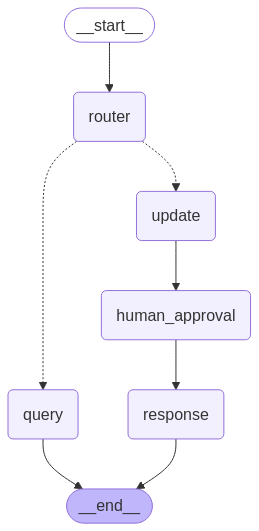

In [28]:
display(Image(account_agent_graph.get_graph().draw_mermaid_png()))

## Test

#### Test fetching account details without providing ID up front

In [29]:
# Input
initial_input = {
    # "messages": [HumanMessage(content="Update my email  address to leonekohler@surfeu.de")], 
    # "messages": [HumanMessage(content="Show me my email address")], 
    "messages": [HumanMessage(content="How much money have I spent in total?")], 
    "next_node": NodeType.ROUTER, 
    "customer_id": 2
}

# Thread
thread = {"configurable": {"thread_id": "customer_id_request_4"}}

# Run the graph - it will stop if an interruption occurs
try:
    for event in account_agent_graph.stream(initial_input, thread, stream_mode="values"):
        # Display messages as they come
        event['messages'][-1].pretty_print()
except Exception as e:
    print(f"Graph execution stopped: {e}")

# Check if there was an interruption
state = account_agent_graph.get_state(thread)
if state.tasks and any(task.interrupts for task in state.tasks):
    # Get the interruption message
    interrupt_task = next(task for task in state.tasks if task.interrupts)
    interrupt_message = interrupt_task.interrupts[0].value
    # Get customer ID from user
    approval = input("Do you approve (yes/no)")
    
    # Validate input
    if approval == "yes":
        # Update the state with the provided customer ID
        account_agent_graph.update_state(
            thread,
            {
                "messages": state.values["messages"],
                "customer_id": state.values["customer_id"],
                "next_node": state.values["next_node"],
                "approved": True
            }
        )
        
        # Continue the graph execution with the updated state
        for event in account_agent_graph.stream(None, thread, stream_mode="values"):
            event['messages'][-1].pretty_print()
    else:
        print("Not approved")

================================ Human Message =================================

How much money have I spent in total?
================================== Ai Message ==================================

This is a query request. Please retrieve the requested information.
================================== Ai Message ==================================

You have spent a total of $38.52 across your purchases. If you need any more details or assistance, feel free to ask!


#### Verify that the update went through

In [30]:
query_customer_info.invoke({"customer_id": 2})

"[(2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'test@this-1.com', 5)]"

# Compound Agent

## Set up graph

### Node: Request Routing

In [31]:
derive_id_message = """Your task is to determine the customer ID from text that represents a sequence of 
queries from the user.
For example, 
1. if a query says 'My customer ID is 123' then you should return 123.
2. if the query says 'I want to switch from talking about customer 123 to customer 456', then return 456.
If the customer ID is not part of the query, return UNKNOWN.
For example, if the query is 'Recommend music from U2', return UNKNOWN.

When the sequence represents a conversation, like:
```My customer ID is 123. Recommend music by U2.

What is the most popular song by Green Day?
```
you should be able to determine that the customer ID is 123

Return ONLY the customer ID number, ex. '123' or the string 'UNKNOWN'
"""

router_system_message = """You are a helpful customer support assistant for a music store.
Your job is to determine what the customer needs help with and route them to the appropriate department:

1. ACCOUNT - For updating personal information, account details, or authentication
2. MUSIC - For music recommendations, searching for songs/artists, or questions about music inventory
3. UNRELATED - for anything that does not fit into ACCOUNT or MUSIC

Respond with only the name of the department (ACCOUNT, MUSIC or UNRELATED) that best matches their query.
You are provided the conversation history of the user. Determine the appropriate department based on their
most recent request.
If they want to access personal information and have not provided a customer ID, please ask for the ID.
"""

def get_customer_id_from_history(state: MusicStoreChatbotState) -> str:
    human_messages = filter_messages(state["messages"], include_types="human")
    formatted_human_messages = "\n\n".join([m.content for m in human_messages])
    derived_id_response = helpdesk_agent_model.invoke([SystemMessage(content=derive_id_message)] + human_messages)
    return derived_id_response.content


def route_conversation(state: MusicStoreChatbotState) -> dict:
    """Route the conversation to the appropriate department"""
    state_update = {}  # stores the partial update returned by this function

    # check if the user ID is available in the latest human query
    derived_id = get_customer_id_from_history(state)
    if derived_id.isdigit() and query_customer_info.invoke({"customer_id": int(derived_id)}) != "":
        state_update["customer_id"] = int(derived_id)
    elif state["customer_id"] is None:
        raise NodeInterrupt(customer_id_interrupt_message)

    human_messages = filter_messages(state["messages"], include_types="human")
    router_messages = [SystemMessage(content=router_system_message)] + human_messages
    response = helpdesk_agent_model.invoke(router_messages)

    # Update the state with the correct department
    content = response.content.lower()
    if "account" in content:
        state_update["current_mode"] = "account"
    elif "music" in content:
        state_update["current_mode"] = "music"
    else:
        state_update["current_mode"] = "unrelated"

    state_update["messages"] = state["messages"] + [SystemMessage(f"Request classified as `{state_update['current_mode']}`")]
    return state_update


def route_condition(state: MusicStoreChatbotState) -> str:
    """Return the routing condition based on the current state"""
    return state["current_mode"]

### Node: Out of Scope Queries

In [32]:
def out_of_scope_message_node(state: MusicStoreChatbotState):
    """Node that mocks an agent that can respond only with a default message for unrelated queries."""
    response = "I can only help with music recommendations and account updates. Please try again"
    return {
        "messages": state["messages"] + [AIMessage(response)]
    }

### Graph definition

In [33]:
front_desk_graph_builder = StateGraph(MusicStoreChatbotState)
front_desk_graph_builder.add_node("route_conversation", route_conversation)
front_desk_graph_builder.add_node("music_node", music_recommendation_graph_builder.compile())
# front_desk_graph_builder.add_node("account_node", account_node)
front_desk_graph_builder.add_node("account_node", account_agent_graph_builder.compile())
front_desk_graph_builder.add_node("out_of_scope_message_node", out_of_scope_message_node)

# Add the starting edge
front_desk_graph_builder.add_edge(START, "route_conversation")

# Add conditional edges - this is the key part
front_desk_graph_builder.add_conditional_edges(
    "route_conversation",  # Source node
    route_condition,  # Function that returns the condition value
    {
        "music": "music_node",
        "account": "account_node",
        "unrelated": "out_of_scope_message_node"
    }
)

# Add the ending edges
front_desk_graph_builder.add_edge("music_node", END)
front_desk_graph_builder.add_edge("account_node", END)
front_desk_graph_builder.add_edge("out_of_scope_message_node", END)

memory = MemorySaver()
front_desk_graph = front_desk_graph_builder.compile(checkpointer=memory)

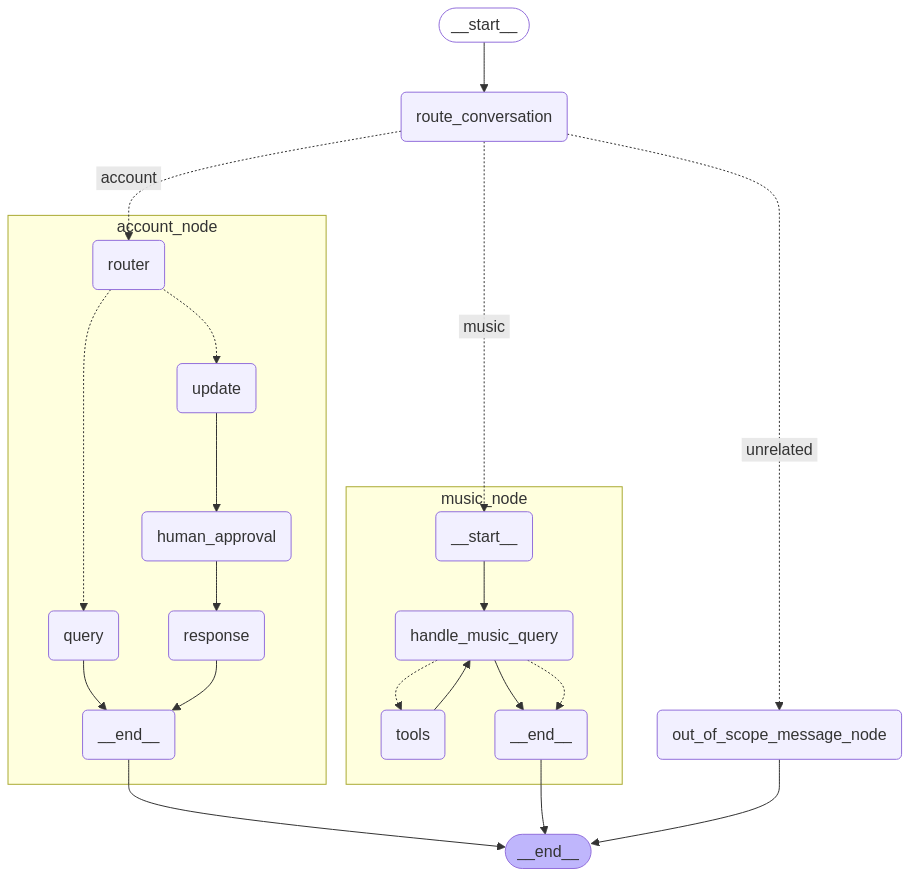

In [34]:
display(Image(front_desk_graph.get_graph(xray=True).draw_mermaid_png()))

# New Execution Logic

In [35]:
def run_agent_with_interruption_handling(message, thread_id=uuid.uuid4(), graph=front_desk_graph):
    """
    Run an agent graph with elegant handling of multiple possible interruptions.
    
    Args:
        graph: The compiled LangGraph to run
        initial_input: The initial state to provide to the graph
        thread_config: Thread configuration dictionary
    
    Returns:
        The final response from the graph
    """
    current_input = {
        "messages": [HumanMessage(content=message)], 
        "current_mode": "router", 
        "next_node": NodeType.ROUTER, 
        "customer_id": None
    }
    thread_config = {"configurable": {"thread_id": thread_id}}
    all_messages = current_input["messages"]
    
    while True:
        
        for event in graph.stream(current_input, thread_config, stream_mode="values"):

            # Add new messages to our collection and display them
            if 'messages' in event and event['messages']:
                new_messages = [msg for msg in event['messages'] if msg not in all_messages]
                all_messages = event['messages']
                
                for msg in [m for m in new_messages if m.type != "system"]:
                    msg.pretty_print()

        # Get the state to check for completion or interruption
        state = graph.get_state(thread_config)
        
        # Check if the graph completed execution
        if state.next == ():
            print("\n✅ Graph execution completed successfully")
            return all_messages

        # If we're here, there might be an interruption
        if state.tasks and any(task.interrupts for task in state.tasks):
            # Find the first task with interrupts
            interrupt_task = next(task for task in state.tasks if task.interrupts)
            interrupt_message = interrupt_task.interrupts[0].value
            node_name = interrupt_task.name
            
            # Handle the interruption based on its type
            interrupt_handler = identify_interrupt_handler(interrupt_message, node_name)
            
            if interrupt_handler:
                # Use the handler to update the state and get new input (if any)
                current_input = interrupt_handler(graph, state, thread_config, interrupt_message)
            else:
                print(f"❌ Unknown interruption type: {interrupt_message}")
                print(state)
                return all_messages
        else:
            # If no tasks with interrupts but graph didn't reach END,
            # something else might be wrong
            print(f"❌ Graph execution stopped unexpectedly")
            return all_messages

def identify_interrupt_handler(interrupt_message, node_name=None):
    """
    Identify the appropriate handler function based on the interruption message.
    
    Args:
        interrupt_message: The message from the interruption
    
    Returns:
        The handler function or None if no matching handler is found
    """
    if customer_id_interrupt_message in interrupt_message:
        return handle_customer_id_interrupt
    elif action_confirmation_interrupt_message in interrupt_message:
        return handle_confirmation_interrupt
    else:
        print(f"❌ Unindentified interrupt message {interrupt_message}")
        return handle_generic_interrupt

def handle_customer_id_interrupt(graph, state, thread_config, interrupt_message):
    """Handle interruption requesting customer ID."""
    customer_id_input = input(f"\n🔍 {interrupt_message}")
    
    # Validate input
    if customer_id_input.isdigit():
        # Update the state with the provided customer ID
        # Why was I doing it this way?
        # new_messages = state.values["messages"] + [
        #     HumanMessage(content=f"My customer ID is {customer_id_input}")
        # ]
        
        graph.update_state(
            thread_config,
            {
                "customer_id": int(customer_id_input),  # "customer_id": state.values.get("customer_id"),
                "current_mode": state.values.get("current_mode", "router"),
                "messages": state.values["messages"], # new_messages
                "next_node": state.values.get("next_node", NodeType.ROUTER),
            }
        )
        
        # No new input needed, just continue with the updated state
        return None
    else:
        return handle_customer_id_interrupt(graph, state, thread_config, interrupt_message)

def handle_confirmation_interrupt(graph, state, thread_config, interrupt_message):
    """Handle interruption requesting confirmation for action."""
    confirmation = input(f"\n{interrupt_message} (yes/no): \n").lower()
    
    if confirmation in ("yes", "y"):
        # Add confirmation message to the conversation
        # new_messages = state.values["messages"] + [
        #     HumanMessage(content="Yes, I confirm.")
        # ]
        
        graph.update_state(
            thread_config,
            {
                "messages": state.values["messages"], # new_messages
                "current_mode": state.values.get("current_mode", "router"),
                "customer_id": state.values.get("customer_id", None),
                "next_node": state.values.get("next_node", NodeType.ROUTER),
                "approved": True
            }
        )
    else:
        # Add rejection message to the conversation
        new_messages = state.values["messages"] + [
            HumanMessage(content="No, I don't want to proceed with this.")
        ]
        
        graph.update_state(
            thread_config,
            {
                "messages": state.values["messages"], # new_messages
                "current_mode": state.values.get("current_mode", "router"),
                "customer_id": state.values.get("customer_id", None),
                "next_node": state.values.get("next_node", NodeType.ROUTER),
                "approved": False
            }
        )


def handle_generic_interrupt(graph, state, thread_config, interrupt_message):
    """Handle any other type of interruption generically."""
    user_response = input(f"\n{interrupt_message} \nYour response: ")
    
    new_messages = state.values["messages"] + [
        HumanMessage(content=user_response)
    ]
    
    graph.update_state(
        thread_config,
        {
            "messages": new_messages,
            "current_mode": state.values.get("current_mode", "router"),
            "customer_id": state.values.get("customer_id", None),
            "next_node": state.values.get("next_node", NodeType.ROUTER),
        }
    )

In [36]:
# messages = run_agent_with_interruption_handling("My Customer ID is 2. I want to update my email to test@this-1.com", thread_id="1")

In [37]:
messages = run_agent_with_interruption_handling("My customer ID is 2. I like U2. What other music should I listen to?", thread_id="21")

docs = [Document(metadata={'id': '7b3a31fb-1b61-4c03-ba75-74bfc6e5ea69', 'ArtistId': 150, 'Name': 'U2'}, page_content='U2'), Document(metadata={'id': 'e6bcc2f8-d0a8-4a4d-b9a4-4735436b930c', 'ArtistId': 84, 'Name': 'Foo Fighters'}, page_content='Foo Fighters'), Document(metadata={'id': '7362381b-9816-4b44-8c7b-39df60044b04', 'ArtistId': 120, 'Name': 'Pink Floyd'}, page_content='Pink Floyd'), Document(metadata={'id': '74ac3c2d-ac9c-4432-b9e8-da1770d82e91', 'ArtistId': 151, 'Name': 'UB40'}, page_content='UB40')]
================================== Ai Message ==================================
Tool Calls:
  get_customer_top_genres (call_uVWvzFI7wStmtnVkS9aOQba9)
 Call ID: call_uVWvzFI7wStmtnVkS9aOQba9
  Args:
    customer_id: 2
  get_customer_top_artists (call_I2yMUyXdXxIejckPUgryw0jG)
 Call ID: call_I2yMUyXdXxIejckPUgryw0jG
  Args:
    customer_id: 2
================================= Tool Message =================================
Name: get_customer_top_genres

[{'Genre': 'Rock', 'PurchaseC

In [38]:
# messages = run_agent_with_interruption_handling("My customer ID is 2. How much money have I spent in total?", thread_id="3")

In [39]:
# messages = run_agent_with_interruption_handling("My customer ID is 2. Can you describe my taste in music?", thread_id="4")

In [40]:
# Hey, my customer ID is 2. Is Boulevard of Broken Dreams available at the store?

In [41]:
query_customer_info.invoke({"customer_id": 2})

"[(2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'test@this-1.com', 5)]"